In [ ]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 46.0MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=1ead7aae50016a3db1c8f833e2a8c82a5054e2851d53e011c205c7ed7ea0a20a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [ ]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 26.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200630-cp36-none-any.whl size=41299 sha256=0dec25d2c71a33474f965245fa77f4043c952a2f177a473300d5bf18d942f6b6
  Stored in directory: /root/.cache/pip/wheels/80/eb/49/83b9d20a804f1b4b163d1c1451c670a2067a00175662516f01
Successfully built fvcore


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 104.1.jpg to 104.1.jpg


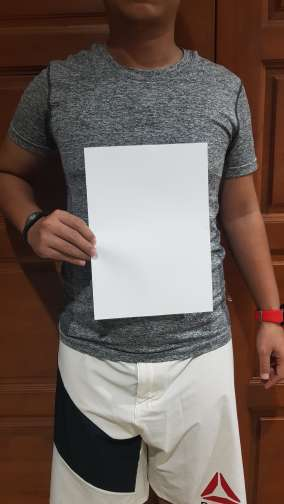

In [ ]:
img = cv2.imread('104.jpg')
cv2_imshow(img)

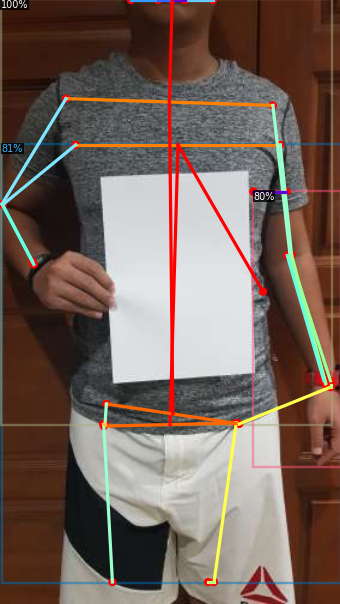

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)
v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 104.jpg to 104.jpg


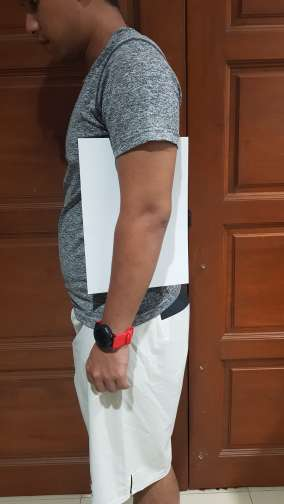

In [ ]:
img2 = cv2.imread('104.1.jpg')
cv2_imshow(img2)

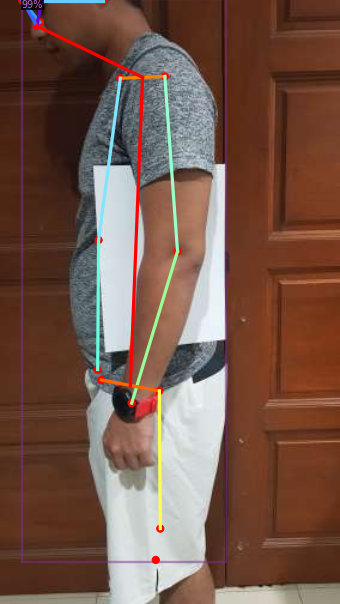

In [ ]:
# Inference with a keypoint detection model
cfg2 = get_cfg()
cfg2.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg2.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg2)
outputs2 = predictor(img2)
v = Visualizer(img2[:,:,::-1], MetadataCatalog.get(cfg2.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip raw_img_test_bg_104_coco.zip > /dev/null

replace raw_img_test_bg_104_coco/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_104_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_project_bg_104.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos[0].items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


get_104_dicts("raw_img_test_bg_104")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving raw_img_test_bg_104_coco.zip to raw_img_test_bg_104_coco.zip


In [ ]:
!unzip raw_img_test_bg_104_coco.zip > /dev/null

replace raw_img_test_bg_104_coco/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.data import DatasetCatalog, MetadataCatalog


register_coco_instances("img_104_1", {}, "raw_img_test_bg_104_coco/via_project_bg_104_coco.json", "raw_img_test_bg_104_coco/image")

In [ ]:
img_104_metadata = MetadataCatalog.get('img_104_1')
img_104_metadata

Metadata(evaluator_type='coco', image_root='raw_img_test_bg_104_coco/image', json_file='raw_img_test_bg_104_coco/via_project_bg_104_coco.json', name='img_104_1')

In [ ]:
dataset_dicts = DatasetCatalog.get("img_104_1")

[06/26 06:07:46 d2.data.datasets.coco]: Loaded 1 images in COCO format from raw_img_test_bg_104_coco/via_project_bg_104_coco.json
WARNING [06/26 06:07:46 d2.data.datasets.coco]: Filtered out 15 instances without valid segmentation. There might be issues in your dataset generation process.


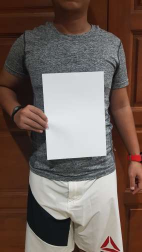

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=img_104_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('img_104',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (300)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 #arm, shoulder, chest, bicep, waist

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("img_104",)
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 1):
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                 metadata = img_104_metadata,
                 scale = 0.8,
                 instance_mode = ColorMode.IMAGE_BW
                 #remove the colors of unsegmented pixels
                 )
  v = v.draw_instance_predictions(outputs['instances'].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])

AttributeError: ignored

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving raw_img_4.zip to raw_img_4.zip


In [ ]:
!unzip raw_img_4.zip > /dev/null

In [ ]:
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.data import DatasetCatalog, MetadataCatalog


register_coco_instances("custlr_img", {}, "raw_img_4/via_project_coco.json", "raw_img_4/")

In [ ]:
custlr_metadata = MetadataCatalog.get('custlr_img')
custlr_metadata

Metadata(evaluator_type='coco', image_root='raw_img_4/', json_file='raw_img_4/via_project_coco.json', name='custlr_img')

In [ ]:
dataset_dicts = DatasetCatalog.get("custlr_img")

[06/30 06:12:49 d2.data.datasets.coco]: Loaded 4 images in COCO format from raw_img_4/via_project_coco.json
WARNING [06/30 06:12:49 d2.data.datasets.coco]: Filtered out 60 instances without valid segmentation. There might be issues in your dataset generation process.


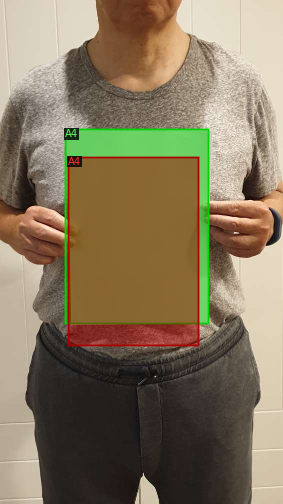

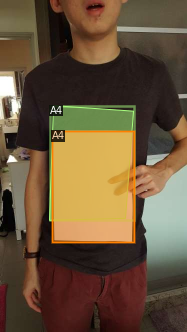

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=custlr_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('custlr_img',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (300)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 #arm, shoulder, chest, bicep, waist

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/30 06:13:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

ValueError: ignored